In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate


# Read the data
INCIDENTS = '../../dataset/data-raw/incidents.csv'
POVERTYYEAY = '../../dataset/data-raw/povertyByStateYear.csv'
STATEDISHOUSE = '../../dataset/data-raw/year_state_district_house.csv'

incidents = pd.read_csv(INCIDENTS)
poverty = pd.read_csv(POVERTYYEAY)
state_district_house = pd.read_csv(STATEDISHOUSE)

incidents['state'] = incidents['state'].str.upper()
poverty['state'] = poverty['state'].str.upper()
state_district_house['state'] = state_district_house['state'].str.upper()

incidents['date_year'] = incidents['date'].str.split('-').str[0].astype(int)
incidents['date_month'] = incidents['date'].str.split('-').str[1].astype(int)
incidents['date_day'] = incidents['date'].str.split('-').str[2].astype(int)
del incidents['date']

incidents = incidents[['date_year', 'date_month', 'date_day', 'state', 'city_or_county', 'latitude', 'longitude', 'congressional_district', 'min_age_participants', 'avg_age_participants', 'max_age_participants', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'incident_characteristics1']].copy()


/tmp/ipykernel_75751/1343187026.py:12: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.read_csv(INCIDENTS)


In [128]:
(incidents['n_participants'] == 0).sum() 

24863

In [117]:
objcols = incidents.select_dtypes(include=['object']).columns
objcols = objcols.drop(['state', 'city_or_county', 'incident_characteristics1'])

for col in objcols:
    incidents[col] = incidents[col].apply(pd.to_numeric, errors='coerce')

In [118]:
# Set the year to NaN if it is greater than 2018 (future)
incidents['date_year'] = incidents['date_year'].apply(lambda year: np.nan if year > 2018 else year)
# If n_participants is 0, set it to NaN
# incidents['n_participants'] = incidents['n_participants'].apply(lambda n: np.nan if n == 0 else n)
# incidents = incidents.dropna(subset=['n_participants'])


In [133]:
import mapply

# Don't ask, it works (maybe)
def mf(row):
    mf = row['n_males'] + row['n_females']
    cta = row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult']
    kiau = row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed']
    p = row['n_participants']

    if mf == cta == kiau == p:
        return 0b0000
    elif mf == cta == kiau:
        if not pd.isna(p):
            return 0b0001
        return 0b0000
    elif mf == cta == p:
        if not pd.isna(kiau):
            return 0b0010
        return 0b0000
    elif mf == kiau == p:
        if not pd.isna(cta):
            return 0b0100
        return 0b0000
    elif cta == kiau == p:
        if not pd.isna(mf):
            return 0b1000
        return 0b0000
    elif mf == p:
        if not pd.isna(cta) and not pd.isna(kiau):
            return 0b0110
        if not pd.isna(cta):
            return 0b0100
        if not pd.isna(kiau):
            return 0b0010
        return 0b0000
    elif cta == p:
        if not pd.isna(mf) and not pd.isna(kiau):
            return 0b1010
        if not pd.isna(mf):
            return 0b1000
        if not pd.isna(kiau):
            return 0b0010
        return 0b0000
    elif kiau == p:
        if not pd.isna(mf) and not pd.isna(cta):
            return 0b1100
        if not pd.isna(mf):
            return 0b1000
        if not pd.isna(cta):
            return 0b0100    
        return 0b0000    
    elif mf == cta:
        if not pd.isna(kiau) and not pd.isna(p):
            return 0b0011
        if not pd.isna(kiau):
            return 0b0010
        if not pd.isna(p):
            return 0b0001
        return 0b0000
    elif mf == kiau:
        if not pd.isna(cta) and not pd.isna(p):
            return 0b0101
        if not pd.isna(cta):
            return 0b0100
        if not pd.isna(p):
            return 0b0001
        return 0b0000
    elif cta == kiau:
        if not pd.isna(mf) and not pd.isna(p):
            return 0b1001
        if not pd.isna(mf):
            return 0b1000
        if not pd.isna(p):
            return 0b0001
        return 0b0000
    return 0b1111
    
def nannifyErrors(row):
    err_bits = mf(row)
    err_p = err_bits & 0b0001
    err_mf = err_bits & 0b1000
    err_cta = err_bits & 0b0100
    err_kiau = err_bits & 0b0010

    if err_p:
        if not (err_mf):
            row['n_participants'] = row['n_males'] + row['n_females']
        elif not (err_cta):
            row['n_participants'] = row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult']
        elif not (err_kiau):
            row['n_participants'] = row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed']
        else:
            row['n_participants'] = np.nan
    if err_mf:
        row['n_males'] = np.nan
        row['n_females'] = np.nan
    if err_cta:
        row['n_participants_child'] = np.nan
        row['n_participants_teen'] = np.nan
        row['n_participants_adult'] = np.nan
    if err_kiau:
        row['n_killed'] = np.nan
        row['n_injured'] = np.nan
        row['n_arrested'] = np.nan
        row['n_unharmed'] = np.nan
    
    return row

mapply.init(n_workers=8, progressbar=True)

diff = incidents.mapply(mf, axis=1)
print('DONE diff')
# incidents without problems
dncidents = incidents[diff == 0b0000]
print('DONE dncidents')
# incidents with problems
wncidents = incidents[diff != 0b0000].mapply(nannifyErrors, axis=1)
print('DONE wncidents')

# dncidents = incidents.iloc[0:10000].apply(nannifyErrors, axis=1)

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Using more workers (8) than is sensible (7). For CPU-bound operations, consider lowering n_workers to avoid bottlenecks on the physical CPUs


  0%|          | 0/64 [00:00<?, ?it/s]

/home/simone/Unipi/InProgress/DM/DM/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Using more workers (8) than is sensible (7). For CPU-bound operations, consider lowering n_workers to avoid bottlenecks on the physical CPUs


DONE diff
DONE dncidents


  0%|          | 0/64 [00:00<?, ?it/s]

DONE wncidents


In [84]:
wncidents.to_csv('../../dataset/data/incidents_with_errors0.csv', index=False)
dncidents.to_csv('../../dataset/data/incidents_without_errors0.csv', index=False)

In [134]:
# merge wncidents with dncidents
wdincidents = pd.concat([wncidents, dncidents], ignore_index=False)

<Axes: xlabel='n_nan'>

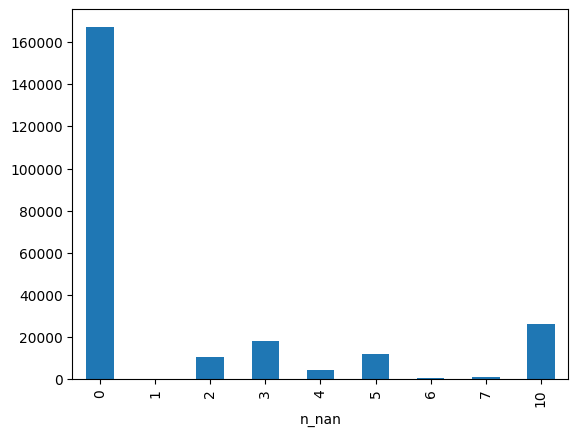

In [135]:
a = wdincidents[['n_participants', 'n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].copy()

# count nan in a rows
a['n_nan'] = a.isnull().sum(axis=1)
a['n_nan'].value_counts().sort_index().plot.bar()

In [136]:
b = a.iloc[0:1000]

In [59]:
# incidents[diff != 0]
print(f'{diff[diff != 0].iloc[0]:b}')
print(incidents[diff != 0].iloc[0])

1100
date_year                                    2016.0
date_month                                       11
date_day                                          5
state                                      MICHIGAN
city_or_county                              Detroit
latitude                                     42.419
longitude                                  -83.0393
congressional_district                         14.0
min_age_participants                            NaN
avg_age_participants                            NaN
max_age_participants                            NaN
n_participants_child                            NaN
n_participants_teen                             NaN
n_participants_adult                            NaN
n_males                                         NaN
n_females                                       NaN
n_killed                                          0
n_injured                                         1
n_arrested                                      0.0
n_unhar

In [89]:
incidents[(~incidents['n_participants'].isna()) * (wdincidents['n_participants'].isna())]

,date_year,date_month,date_day,state,city_or_county,latitude,longitude,congressional_district,min_age_participants,avg_age_participants,...,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1
3,2016.0,10,15,DISTRICT OF COLUMBIA,Washington,38.9030,-76.9820,1.0,248339.0,707477.0,...,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured
25,2015.0,6,2,LOUISIANA,New Orleans,29.9634,-90.0598,2.0,35.0,35.0,...,0.0,1.0,1.0,0.0,0,0,NaN,NaN,2.0,Armed robbery with injury/death and/or evidenc...
35,NaN,11,2,ILLINOIS,Rockford,42.2704,-88.9703,16.0,NaN,NaN,...,0.0,1.0,1.0,0.0,0,0,0.0,1.0,2.0,Defensive Use
37,2017.0,5,25,ARKANSAS,Little Rock,34.7219,-92.3574,2.0,30.0,30.0,...,0.0,1.0,1.0,0.0,0,0,0.0,1.0,4.0,Shots Fired - No Injuries
44,2014.0,10,25,MICHIGAN,Clarkston,42.7313,-83.3795,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,NaN,1.0,Institution/Group/Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239443,2016.0,7,6,CALIFORNIA,Fresno,36.7160,-119.7940,16.0,NaN,637932.0,...,0.0,3.0,1.0,2.0,0,3,0.0,0.0,4.0,Shot - Wounded/Injured
239538,2014.0,9,7,INDIANA,Richmond,39.8217,-84.8904,6.0,34.0,34.0,...,0.0,1.0,1.0,0.0,0,0,0.0,1.0,2.0,Drug involvement
239542,2016.0,9,16,CALIFORNIA,Bakersfield,35.3760,-118.9650,23.0,24.0,24.0,...,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured
239562,2016.0,6,20,OHIO,Columbus,39.9612,-82.9988,3.0,19.0,19.0,...,0.0,1.0,1.0,0.0,0,1,0.0,0.0,3.0,Shot - Wounded/Injured
